In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz
from tqdm import tqdm

In [2]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('confusion.png')
    plt.show()

In [3]:
df = pd.read_csv('../input/PS_20174392719_1491204439457_log.csv')
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

In [4]:
df.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df.loc[df.isFraud == 1].type.drop_duplicates().values

array(['TRANSFER', 'CASH_OUT'], dtype=object)

In [6]:
df = df[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

In [7]:
len(df)

2770409

In [8]:
df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')].amount.median()

445705.76

In [9]:
df.loc[(df.isFraud == 0) & (df.type == 'TRANSFER')].amount.median()

486521.91000000003

In [10]:
df['Fraud_Heuristic'] = np.where(((df['type'] == 'TRANSFER') & 
                                  (df['amount'] > 200000)),1,0)

In [11]:
df['Fraud_Heuristic'].sum()

409110

In [12]:
from sklearn.metrics import f1_score

In [13]:
f1_score(y_pred=df['Fraud_Heuristic'],y_true=df['isFraud'])

0.013131315551742895

In [14]:
from sklearn.metrics import confusion_matrix

In [15]:
cm = confusion_matrix(y_pred=df['Fraud_Heuristic'],y_true=df['isFraud'])

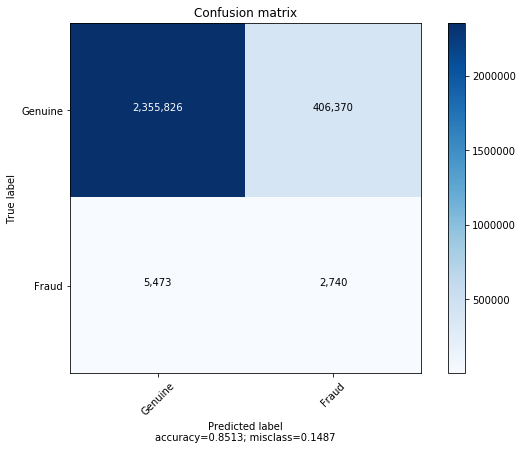

In [16]:
plot_confusion_matrix(cm,['Genuine','Fraud'], normalize=False)

In [17]:
df.shape

(2770409, 12)

In [18]:
df['hour'] = df['step'] % 24

In [19]:
frauds = []
genuine = []
for i in range(24):
    f = len(df[(df['hour'] == i) & (df['isFraud'] == 1)])
    g = len(df[(df['hour'] == i) & (df['isFraud'] == 0)])
    frauds.append(f)
    genuine.append(g)

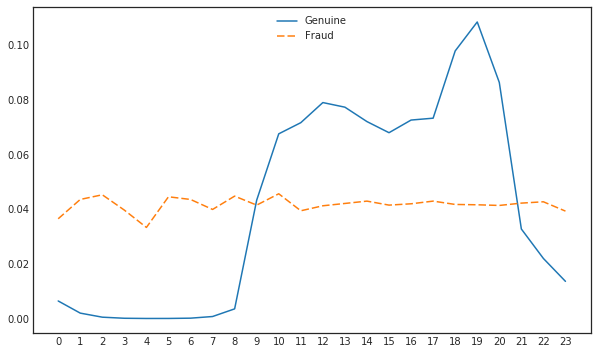

In [20]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(10,6))
gen = ax.plot(genuine/np.sum(genuine), label='Genuine')
fr = ax.plot(frauds/np.sum(frauds),dashes=[5, 2], label='Fraud')
#frgen = ax.plot(np.devide(frauds,genuine),dashes=[1, 1], label='Fraud vs Genuine')
plt.xticks(np.arange(24))
legend = ax.legend(loc='upper center', shadow=True)
fig.savefig('time.png')

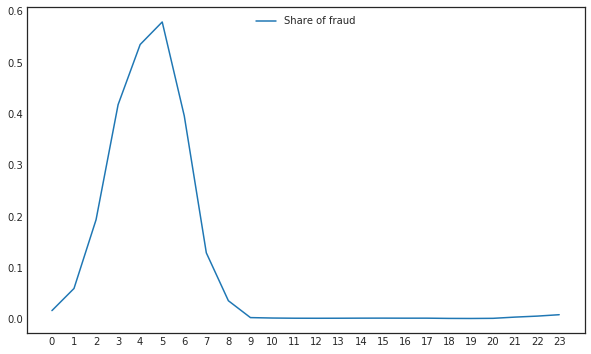

In [21]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(10,6))
#gen = ax.plot(genuine/np.sum(genuine), label='Genuine')
#fr = ax.plot(frauds/np.sum(frauds),dashes=[5, 2], label='Fraud')
frgen = ax.plot(np.divide(frauds,np.add(genuine,frauds)), label='Share of fraud')
plt.xticks(np.arange(24))
legend = ax.legend(loc='upper center', shadow=True)
fig.savefig('time_comp.png')

In [22]:
dfFraudTransfer = df[(df.isFraud == 1) & (df.type == 'TRANSFER')]

In [23]:
dfFraudCashOut = df[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

In [24]:
dfFraudTransfer.nameDest.isin(dfFraudCashOut.nameOrig).any()

False

In [25]:
dfNotFraud = df[(df.isFraud == 0)]

In [26]:
dfFraud = df[(df.isFraud == 1)]

In [27]:
dfFraudTransfer.loc[dfFraudTransfer.nameDest.isin(
    dfNotFraud.loc[dfNotFraud.type == 'CASH_OUT'].nameOrig.drop_duplicates())]

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,Fraud_Heuristic,hour
1030443,65,TRANSFER,1282971.57,C1175896731,1282971.57,0.0,C1714931087,0.0,0.0,1,0,1,17
6039814,486,TRANSFER,214793.32,C2140495649,214793.32,0.0,C423543548,0.0,0.0,1,0,1,6
6362556,738,TRANSFER,814689.88,C2029041842,814689.88,0.0,C1023330867,0.0,0.0,1,0,1,18


In [28]:
len(dfFraud[(dfFraud.oldBalanceDest == 0) & (dfFraud.newBalanceDest == 0) & (dfFraud.amount)]) / (1.0 * len(dfFraud))

0.4955558261293072

In [29]:
len(dfNotFraud[(dfNotFraud.oldBalanceDest == 0) & (dfNotFraud.newBalanceDest == 0) & (dfNotFraud.amount)]) / (1.0 * len(dfNotFraud))

0.0006176245277308345

In [30]:
dfOdd = df[(df.oldBalanceDest == 0) & 
           (df.newBalanceDest == 0) & 
           (df.amount)]

In [31]:
len(dfOdd[(dfOdd.isFraud == 1)]) / len(dfOdd)

0.7046398891966759

In [32]:
len(dfOdd[(dfOdd.oldBalanceOrig <= dfOdd.amount)]) / len(dfOdd)

0.8966412742382271

In [33]:
len(dfOdd[(dfOdd.oldBalanceOrig <= dfOdd.amount) & (dfOdd.isFraud == 1)]) / len(dfOdd[(dfOdd.isFraud == 1)])

0.9636363636363636

In [34]:
dfOdd.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldBalanceOrig',
       'newBalanceOrig', 'nameDest', 'oldBalanceDest', 'newBalanceDest',
       'isFraud', 'isFlaggedFraud', 'Fraud_Heuristic', 'hour'],
      dtype='object')

In [35]:
dfOdd.head(20)

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,Fraud_Heuristic,hour
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.0,1,0,0,1
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.00,C972765878,0.0,0.0,1,0,0,1
680,1,TRANSFER,20128.00,C137533655,20128.00,0.00,C1848415041,0.0,0.0,1,0,0,1
969,1,TRANSFER,1277212.77,C1334405552,1277212.77,0.00,C431687661,0.0,0.0,1,0,1,1
1115,1,TRANSFER,35063.63,C1364127192,35063.63,0.00,C1136419747,0.0,0.0,1,0,0,1
1248,1,TRANSFER,271161.74,C1658487789,0.00,0.00,C1219161283,0.0,0.0,0,0,1,1
1869,1,TRANSFER,25071.46,C669700766,25071.46,0.00,C1384210339,0.0,0.0,1,0,0,1
2301,1,TRANSFER,235238.66,C1872047468,235238.66,0.00,C116289363,0.0,0.0,1,0,1,1
3059,2,TRANSFER,1096187.24,C1093223281,1096187.24,0.00,C2063275841,0.0,0.0,1,0,1,2
3162,2,TRANSFER,963532.14,C1440057381,963532.14,0.00,C268086000,0.0,0.0,1,0,1,2


In [36]:
df.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,Fraud_Heuristic,hour
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,0,1
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,0,1
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,1,1
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,1,1


In [37]:
df['type'] = 'type_' + df['type'].astype(str)

In [38]:
# Get dummies
dummies = pd.get_dummies(df['type'])

# Add dummies to df
df = pd.concat([df,dummies],axis=1)

#remove original column
del df['type']

Predictive modeling with Keras

In [41]:
df = df.drop(['nameOrig','nameDest','Fraud_Heuristic'], axis= 1)

In [49]:
df['isNight'] = np.where((2 <= df['hour']) & (df['hour'] <= 6), 1,0)

In [50]:
df[df['isNight'] == 1].isFraud.mean()

0.35705263157894734

In [51]:
df.head()

,step,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,hour,type_CASH_OUT,type_TRANSFER,isNight
2,1,181.00,181.0,0.0,0.0,0.00,1,0,1,0,1,0
3,1,181.00,181.0,0.0,21182.0,0.00,1,0,1,1,0,0
15,1,229133.94,15325.0,0.0,5083.0,51513.44,0,0,1,1,0,0
19,1,215310.30,705.0,0.0,22425.0,0.00,0,0,1,0,1,0
24,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,0,1,0,1,0


In [53]:
df = df.drop(['step','hour'],axis=1)

In [54]:
df.head()

,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_TRANSFER,isNight
2,181.00,181.0,0.0,0.0,0.00,1,0,0,1,0
3,181.00,181.0,0.0,21182.0,0.00,1,0,1,0,0
15,229133.94,15325.0,0.0,5083.0,51513.44,0,0,1,0,0
19,215310.30,705.0,0.0,22425.0,0.00,0,0,0,1,0
24,311685.89,10835.0,0.0,6267.0,2719172.89,0,0,0,1,0


In [56]:
df.columns.values

array(['amount', 'oldBalanceOrig', 'newBalanceOrig', 'oldBalanceDest',
       'newBalanceDest', 'isFraud', 'isFlaggedFraud', 'type_CASH_OUT',
       'type_TRANSFER', 'isNight'], dtype=object)

In [58]:
y_df = df['isFraud']
x_df = df.drop('isFraud',axis=1)

In [59]:
y = y_df.values
X = x_df.values

In [60]:
y.shape

(2770409,)

In [61]:
X.shape

(2770409, 9)

In [62]:
from sklearn.model_selection import train_test_split

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, 
                                                    random_state=42)

In [85]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                    test_size=0.1, 
                                                    random_state=42)

In [86]:
from imblearn.over_sampling import SMOTE, RandomOverSampler

In [96]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [194]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

In [195]:
# Log reg
model = Sequential()
model.add(Dense(1, input_dim=9))
model.add(Activation('sigmoid'))

In [196]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 1)                 10        
_________________________________________________________________
activation_20 (Activation)   (None, 1)                 0         
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


In [197]:
model.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=1e-5), 
              metrics=['acc'])

In [199]:
model.fit(X_train_res,y_train_res,
          epochs=5, 
          batch_size=256, 
          validation_data=(X_val,y_val))

Train on 3331258 samples, validate on 185618 samples
Epoch 1/5
3331258/3331258 [==============================] - 21s 6us/step - loss: 0.7453 - acc: 0.4799 - val_loss: 0.4254 - val_acc: 0.9733
Epoch 2/5
1411840/3331258 [===========>..................] - ETA: 11s - loss: 0.7419 - acc: 0.4797

KeyboardInterrupt: 

In [144]:
y_pred = model.predict(X_test)

In [145]:
y_pred[y_pred > 0.5] = 1
y_pred[y_pred < 0.5] = 0

In [146]:
f1_score(y_pred=y_pred,y_true=y_test)

0.054384286716408395

In [147]:
cm = confusion_matrix(y_pred=y_pred,y_true=y_test)

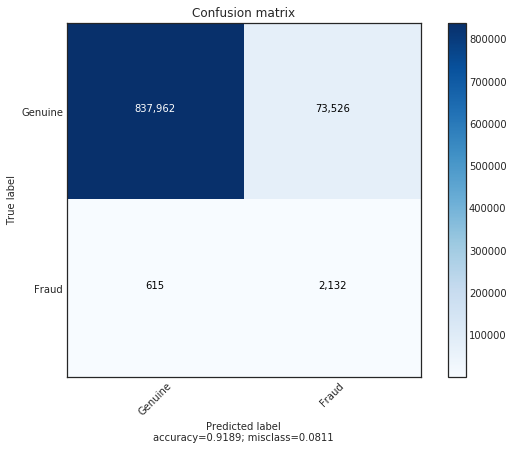

In [149]:
plot_confusion_matrix(cm,['Genuine','Fraud'], normalize=False)

In [200]:
model = Sequential()
model.add(Dense(16,input_dim=9))
model.add(Activation('tanh'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [203]:
model.compile(loss='binary_crossentropy',optimizer=SGD(lr=1e-4), metrics=['acc'])

In [205]:
model.fit(X_train_res,y_train_res,
          epochs=5, batch_size=256, 
          validation_data=(X_val,y_val))

Train on 3331258 samples, validate on 185618 samples
Epoch 1/5
3331258/3331258 [==============================] - 22s 7us/step - loss: 0.6064 - acc: 0.6922 - val_loss: 1.0665 - val_acc: 0.1872
Epoch 2/5
 729856/3331258 [=====>........................] - ETA: 17s - loss: 0.6029 - acc: 0.6968

KeyboardInterrupt: 

In [206]:
y_pred = model.predict(X_test)

In [207]:
y_pred[y_pred > 0.5] = 1
y_pred[y_pred < 0.5] = 0

In [208]:
f1_score(y_pred=y_pred,y_true=y_test)

0.001674751441885722

In [138]:
cm = confusion_matrix(y_pred=y_pred,y_true=y_test)

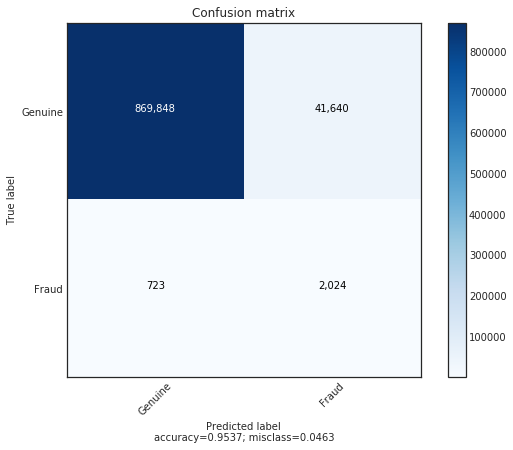

In [139]:
plot_confusion_matrix(cm,['Genuine','Fraud'], normalize=False)

# Tree based methods

In [150]:
from sklearn.tree import export_graphviz

In [151]:
from sklearn.tree import DecisionTreeClassifier
dtree=DecisionTreeClassifier()
dtree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

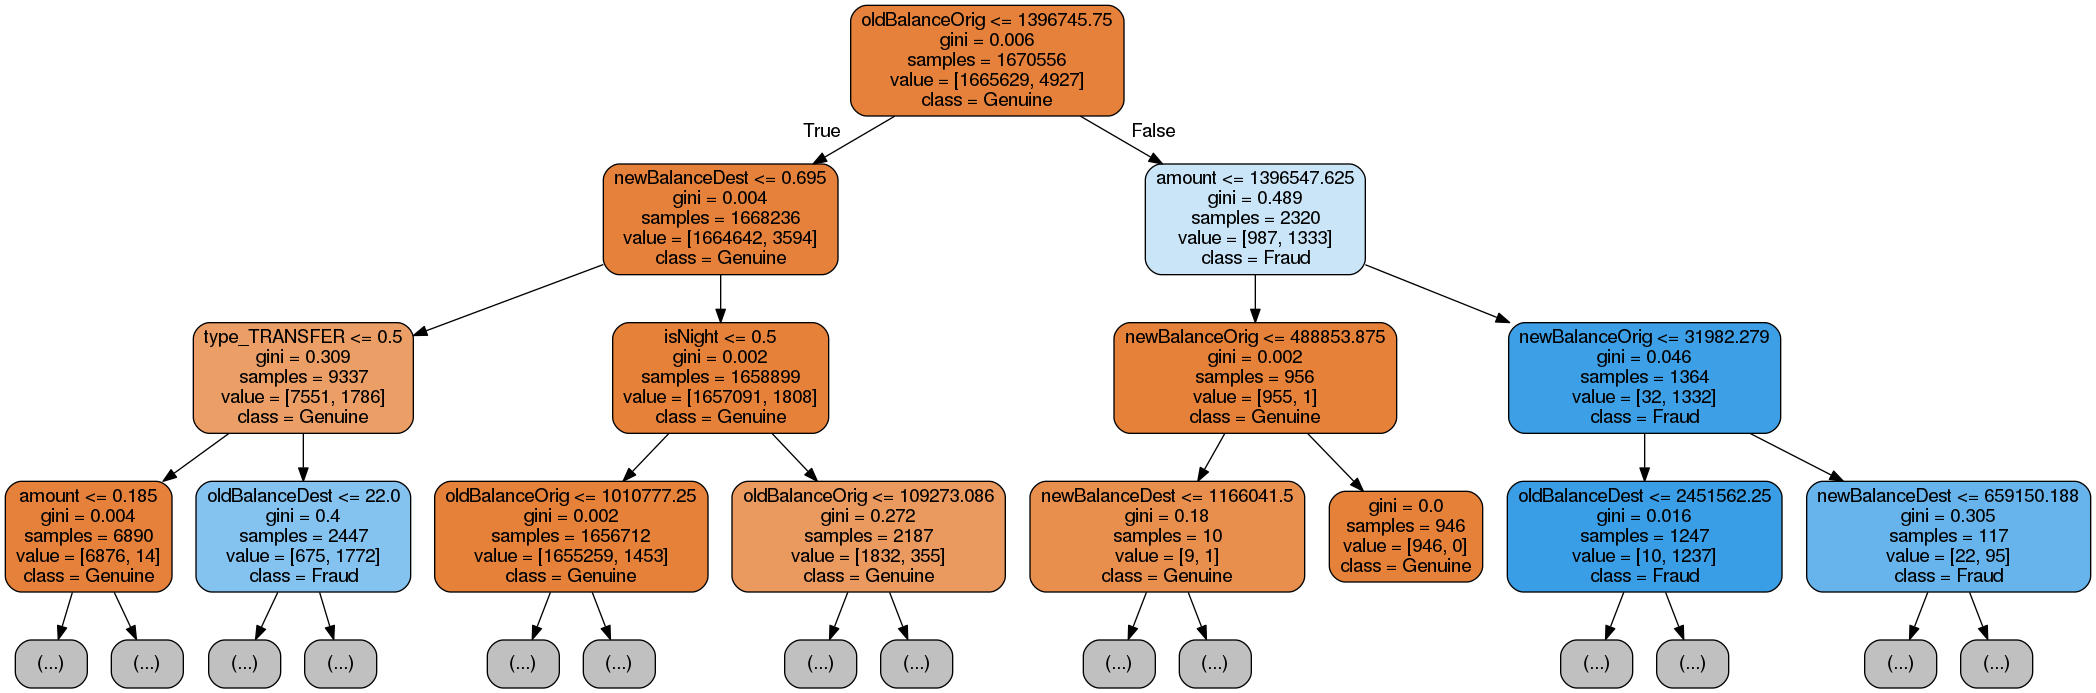

In [162]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
from IPython.display import Image as PImage

#import pydotplus
dot_data = StringIO()
'''export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)'''
with open("tree1.dot", 'w') as f:
     f = export_graphviz(dtree,
                              out_file=f,
                              max_depth = 3,
                              impurity = True,
                              feature_names = list(df.drop(['isFraud'], axis=1)),
                              class_names = ['Genuine', 'Fraud'],
                              rounded = True,
                              filled= True )
        
#Convert .dot to .png to allow display in web notebook
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

# Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
font = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', 26)
img.save('sample-out.png')
PImage("sample-out.png")


In [163]:
from sklearn.ensemble import  RandomForestClassifier

In [176]:
rf = RandomForestClassifier(n_estimators=10,n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [179]:
y_pred = rf.predict(X_test)

In [180]:
f1_score(y_pred=y_pred,y_true=y_test)

0.8749502190362406

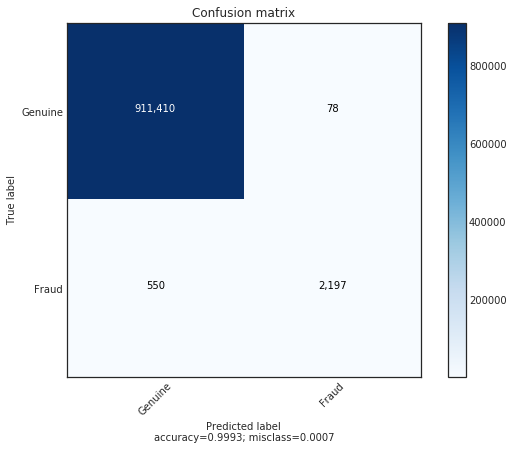

In [181]:
cm = confusion_matrix(y_pred=y_pred,y_true=y_test)
plot_confusion_matrix(cm,['Genuine','Fraud'], normalize=False)

In [182]:
import xgboost as xgb

In [186]:
booster = xgb.XGBClassifier(n_jobs=-1)
booster = booster.fit(X_train,y_train)

In [188]:
y_pred = booster.predict(X_test)

In [189]:
f1_score(y_pred=y_pred,y_true=y_test)

0.85572959604286891

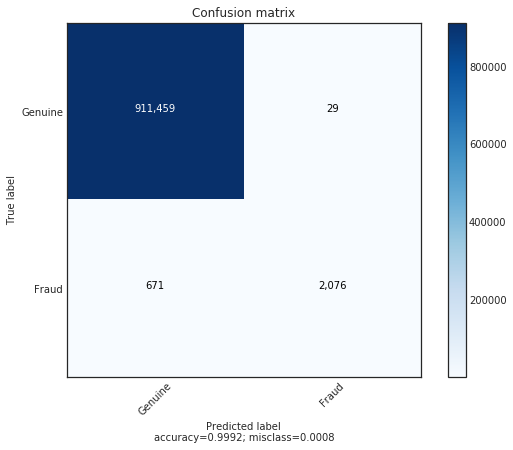

In [190]:
cm = confusion_matrix(y_pred=y_pred,y_true=y_test)
plot_confusion_matrix(cm,['Genuine','Fraud'], normalize=False)

# Entity embeddings

In [ ]:
# Reload data
df = pd.read_csv('../input/PS_20174392719_1491204439457_log.csv')
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

In [ ]:
df.head()

In [ ]:
df = df.drop(['nameDest','nameOrig','step'],axis=1)

In [ ]:
df['type'].unique()

In [ ]:
map_dict = {}
for token, value in enumerate(df['type'].unique()):
    map_dict[value] = token   

In [ ]:
map_dict

In [ ]:
df["type"].replace(map_dict, inplace=True)

In [ ]:
df.head()

In [ ]:
other_cols = [c for c in df.columns if ((c != 'type') and (c != 'isFraud'))]

In [ ]:
other_cols

In [ ]:
from keras.models import Model
from keras.layers import Embedding, Merge, Dense, Activation, Reshape, Input, Concatenate

In [ ]:
num_types = len(df['type'].unique())
type_embedding_dim = 3

In [ ]:
inputs = []
outputs = []

In [ ]:
type_in = Input(shape=(1,))
type_embedding = Embedding(num_types,type_embedding_dim,input_length=1)(type_in)
type_out = Reshape(target_shape=(type_embedding_dim,))(type_embedding)

type_model = Model(type_in,type_out)

inputs.append(type_in)
outputs.append(type_out)

In [ ]:
num_rest = len(other_cols)

In [ ]:
rest_in = Input(shape = (num_rest,))
rest_out = Dense(16)(rest_in)

rest_model = Model(rest_in,rest_out)

inputs.append(rest_in)
outputs.append(rest_out)

In [ ]:
concatenated = Concatenate()(outputs)

In [ ]:
x = Dense(16)(concatenated)
x = Activation('sigmoid')(x)
x = Dense(1)(concatenated)
model_out = Activation('sigmoid')(x)

In [ ]:
merged_model = Model(inputs, model_out)
merged_model.compile(loss='binary_crossentropy', 
                     optimizer='adam', 
                     metrics=['accuracy'])

In [ ]:
types = df['type']

In [ ]:
rest = df[other_cols]

In [ ]:
target = df['isFraud']

In [ ]:
history = merged_model.fit([types.values,rest.values],target.values, 
                           epochs = 1, batch_size = 128)

In [ ]:
merged_model.summary()